# Imports and Data Download

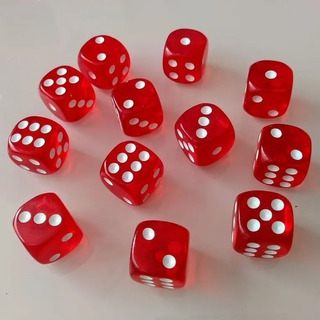

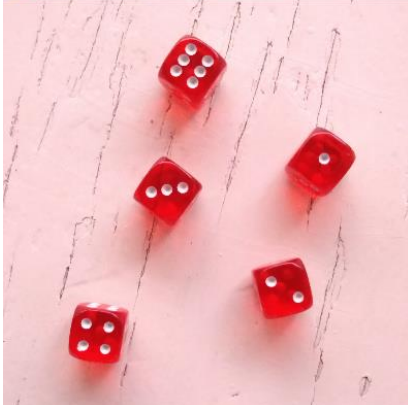

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow as imshow
from sklearn.cluster import DBSCAN as dbs

names_list = ["dados2.jpg", "dados3.png"]

img_list = []
for name in names_list:
  img_list.append(cv.imread(name))
  imshow(img_list[-1])

# Algorithm

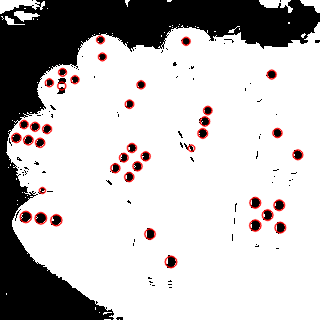

'Number of dice rolled: '

12

'Sum of the roll: '

39

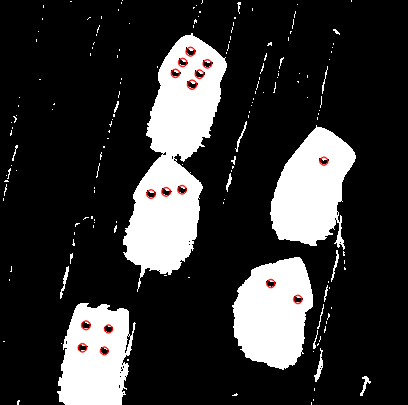

'Number of dice rolled: '

5

'Sum of the roll: '

16

In [ ]:
for img in img_list:
  #img = cv.GaussianBlur(img, (3, 3), 0)
  #img = cv.medianBlur(img,3)
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  (thresh, img) = cv.threshold(img, 180, 255, cv.THRESH_BINARY)
  img = cv.bitwise_not(img)

# Detecting dots

  params = cv.SimpleBlobDetector_Params()

  #params.minThreshold = 90;
  #params.maxThreshold = 255;

  #params.filterByCircularity
  #params.minCircularity = 0.6

  params.filterByConvexity = True
  params.minConvexity = 0.2

 # params.filterByInertia
 # params.minInertiaRatio = 0.4

  detector = cv.SimpleBlobDetector_create(params)
  dots = detector.detect(img)
  img = cv.drawKeypoints(img, dots, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  imshow(img)

# Clusterization
  coords = []
  for dot in dots:
    dot = dot.pt
    coords.append(dot)
  
  clusters = dbs(eps=35, min_samples=1).fit(coords)

  labels = np.unique(clusters.labels_)

  roll_sum = len(clusters.labels_)
  dice_number = len(labels)


  display("Number of dice rolled: ",dice_number)
  display("Sum of the roll: ", roll_sum)